In [295]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import time
import datetime
import random

In [296]:
# sprawdzenie dostępnych urządzeń
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [297]:
class Colors:
    GREEN = "green"
    RED = "red"
    BLACK = "black"

def get_color_from_number(number: int) -> str:
    if number == 0:
        return Colors.GREEN
    if 0 < number <= 7:
        return Colors.RED
    if 8 <= number <= 14:
        return Colors.BLACK
    else:
        raise Exception("Number not in acceptable range")

def get_color_number_from_color(color: str) -> int:
    if color is Colors.GREEN:
        return 0
    if color is Colors.RED:
        return 1
    if color is Colors.BLACK:
        return 2
    else:
        print(color)
        raise Exception("Color not handled")

def split_list(lst, chunk_size) -> tuple[list[str], list[str]]:
    data = []
    labels = []
    for i in range(len(lst) - chunk_size):
        data.append(lst[i:i+chunk_size])
        labels.append(lst[i+chunk_size])
    return data, labels

In [298]:
raw_data = [random.randint(0, 14) for _ in range(10000)]
raw_data

[1,
 11,
 11,
 5,
 8,
 4,
 5,
 13,
 12,
 13,
 14,
 3,
 14,
 11,
 10,
 12,
 4,
 0,
 8,
 12,
 3,
 3,
 12,
 8,
 14,
 2,
 2,
 1,
 14,
 4,
 1,
 13,
 3,
 9,
 7,
 5,
 0,
 10,
 9,
 10,
 2,
 10,
 6,
 10,
 1,
 14,
 9,
 5,
 7,
 14,
 0,
 1,
 5,
 8,
 1,
 8,
 4,
 2,
 9,
 11,
 10,
 6,
 8,
 13,
 9,
 1,
 2,
 2,
 0,
 12,
 5,
 9,
 10,
 10,
 11,
 9,
 0,
 11,
 12,
 10,
 9,
 10,
 4,
 2,
 14,
 11,
 7,
 8,
 0,
 0,
 0,
 0,
 13,
 13,
 13,
 4,
 5,
 3,
 4,
 3,
 14,
 10,
 5,
 9,
 6,
 13,
 1,
 8,
 3,
 14,
 11,
 12,
 6,
 3,
 4,
 8,
 3,
 11,
 10,
 12,
 10,
 10,
 10,
 0,
 2,
 3,
 1,
 11,
 1,
 14,
 8,
 1,
 6,
 7,
 2,
 2,
 3,
 4,
 3,
 8,
 9,
 14,
 14,
 3,
 1,
 10,
 12,
 4,
 8,
 4,
 10,
 9,
 3,
 2,
 5,
 3,
 10,
 14,
 10,
 13,
 6,
 6,
 8,
 1,
 13,
 12,
 1,
 2,
 12,
 4,
 1,
 0,
 14,
 4,
 12,
 14,
 12,
 4,
 1,
 5,
 12,
 6,
 13,
 0,
 5,
 8,
 4,
 5,
 5,
 13,
 4,
 11,
 3,
 0,
 3,
 3,
 5,
 11,
 4,
 7,
 2,
 12,
 7,
 11,
 6,
 0,
 3,
 4,
 0,
 7,
 5,
 10,
 11,
 1,
 11,
 0,
 8,
 10,
 3,
 7,
 7,
 6,
 13,
 10,
 11,
 8,
 8,
 2,
 7,
 4,

In [299]:
colors = list(map(get_color_from_number, raw_data))
colors

['red',
 'black',
 'black',
 'red',
 'black',
 'red',
 'red',
 'black',
 'black',
 'black',
 'black',
 'red',
 'black',
 'black',
 'black',
 'black',
 'red',
 'green',
 'black',
 'black',
 'red',
 'red',
 'black',
 'black',
 'black',
 'red',
 'red',
 'red',
 'black',
 'red',
 'red',
 'black',
 'red',
 'black',
 'red',
 'red',
 'green',
 'black',
 'black',
 'black',
 'red',
 'black',
 'red',
 'black',
 'red',
 'black',
 'black',
 'red',
 'red',
 'black',
 'green',
 'red',
 'red',
 'black',
 'red',
 'black',
 'red',
 'red',
 'black',
 'black',
 'black',
 'red',
 'black',
 'black',
 'black',
 'red',
 'red',
 'red',
 'green',
 'black',
 'red',
 'black',
 'black',
 'black',
 'black',
 'black',
 'green',
 'black',
 'black',
 'black',
 'black',
 'black',
 'red',
 'red',
 'black',
 'black',
 'red',
 'black',
 'green',
 'green',
 'green',
 'green',
 'black',
 'black',
 'black',
 'red',
 'red',
 'red',
 'red',
 'red',
 'black',
 'black',
 'red',
 'black',
 'red',
 'black',
 'red',
 'black',
 're

In [300]:
DATA_CHUNK_SIZE = 5
colors = list(map(get_color_number_from_color, colors))
data, labels = split_list(colors, DATA_CHUNK_SIZE)

In [301]:
data

[[1, 2, 2, 1, 2],
 [2, 2, 1, 2, 1],
 [2, 1, 2, 1, 1],
 [1, 2, 1, 1, 2],
 [2, 1, 1, 2, 2],
 [1, 1, 2, 2, 2],
 [1, 2, 2, 2, 2],
 [2, 2, 2, 2, 1],
 [2, 2, 2, 1, 2],
 [2, 2, 1, 2, 2],
 [2, 1, 2, 2, 2],
 [1, 2, 2, 2, 2],
 [2, 2, 2, 2, 1],
 [2, 2, 2, 1, 0],
 [2, 2, 1, 0, 2],
 [2, 1, 0, 2, 2],
 [1, 0, 2, 2, 1],
 [0, 2, 2, 1, 1],
 [2, 2, 1, 1, 2],
 [2, 1, 1, 2, 2],
 [1, 1, 2, 2, 2],
 [1, 2, 2, 2, 1],
 [2, 2, 2, 1, 1],
 [2, 2, 1, 1, 1],
 [2, 1, 1, 1, 2],
 [1, 1, 1, 2, 1],
 [1, 1, 2, 1, 1],
 [1, 2, 1, 1, 2],
 [2, 1, 1, 2, 1],
 [1, 1, 2, 1, 2],
 [1, 2, 1, 2, 1],
 [2, 1, 2, 1, 1],
 [1, 2, 1, 1, 0],
 [2, 1, 1, 0, 2],
 [1, 1, 0, 2, 2],
 [1, 0, 2, 2, 2],
 [0, 2, 2, 2, 1],
 [2, 2, 2, 1, 2],
 [2, 2, 1, 2, 1],
 [2, 1, 2, 1, 2],
 [1, 2, 1, 2, 1],
 [2, 1, 2, 1, 2],
 [1, 2, 1, 2, 2],
 [2, 1, 2, 2, 1],
 [1, 2, 2, 1, 1],
 [2, 2, 1, 1, 2],
 [2, 1, 1, 2, 0],
 [1, 1, 2, 0, 1],
 [1, 2, 0, 1, 1],
 [2, 0, 1, 1, 2],
 [0, 1, 1, 2, 1],
 [1, 1, 2, 1, 2],
 [1, 2, 1, 2, 1],
 [2, 1, 2, 1, 1],
 [1, 2, 1, 1, 2],
 [2, 1, 1,

In [302]:
labels

[1,
 1,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 1,
 0,
 2,
 2,
 1,
 1,
 2,
 2,
 2,
 1,
 1,
 1,
 2,
 1,
 1,
 2,
 1,
 2,
 1,
 1,
 0,
 2,
 2,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 2,
 1,
 1,
 2,
 0,
 1,
 1,
 2,
 1,
 2,
 1,
 1,
 2,
 2,
 2,
 1,
 2,
 2,
 2,
 1,
 1,
 1,
 0,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 1,
 1,
 2,
 2,
 1,
 2,
 0,
 0,
 0,
 0,
 2,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 2,
 2,
 1,
 1,
 1,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 1,
 1,
 1,
 2,
 1,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 1,
 1,
 2,
 2,
 1,
 2,
 1,
 2,
 2,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 1,
 1,
 2,
 1,
 2,
 2,
 1,
 1,
 2,
 1,
 1,
 0,
 2,
 1,
 2,
 2,
 2,
 1,
 1,
 1,
 2,
 1,
 2,
 0,
 1,
 2,
 1,
 1,
 1,
 2,
 1,
 2,
 1,
 0,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 2,
 1,
 2,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 2,
 2,
 1,
 2,
 0,
 2,
 2,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 2,
 0,
 2,
 1,
 1,
 1,
 2,
 0,
 2,
 1,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 1,
 1,
 1,
 1,


In [336]:
data_zip = list(zip(data, labels))
random.shuffle(data_zip)
data = [np.asarray(el[0]) for el in data_zip]
labels = [np.asarray(el[1]) for el in data_zip]
X_train, X_test, y_train, y_test = train_test_split(np.asarray(data), np.asarray(labels), test_size=0.33)

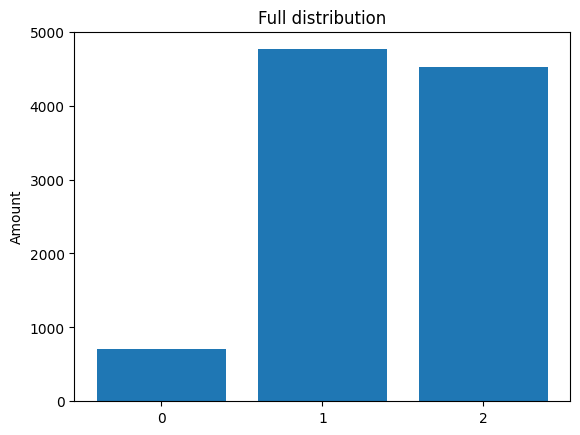

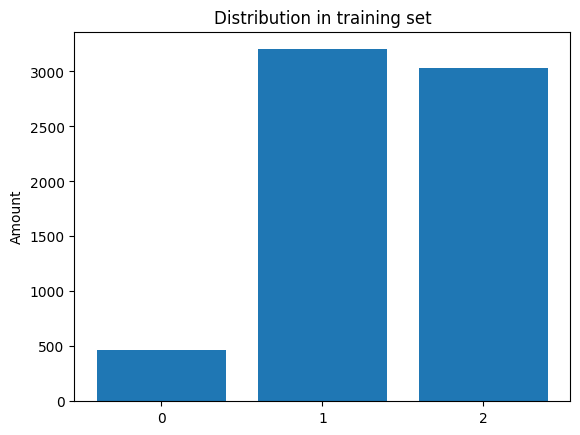

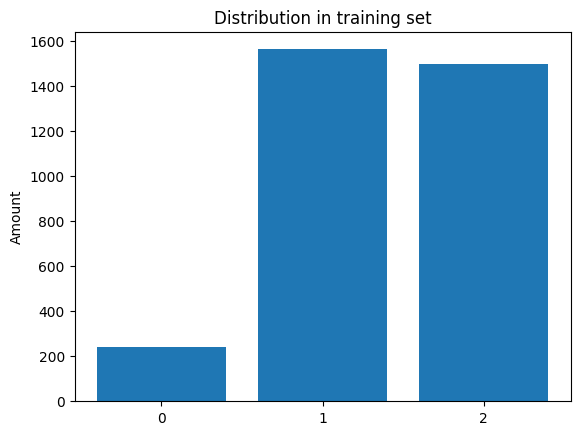

In [304]:
distinct_labels = list(set(labels))
labels_list = list(labels)
distinct_labels_counts = [labels_list.count(label) for label in distinct_labels]

y_pos = np.arange(len(distinct_labels))
plt.bar(y_pos, distinct_labels_counts, align='center', alpha=1)
plt.xticks(y_pos, distinct_labels)
plt.ylabel('Amount')
plt.title('Full distribution')
plt.show()
    
    
y_train_distinct_labels_counts = [list(y_train).count(label) for label in distinct_labels]
y_pos = np.arange(len(distinct_labels))
plt.bar(y_pos, y_train_distinct_labels_counts, align='center')
plt.xticks(y_pos, distinct_labels)
plt.ylabel('Amount')
plt.title('Distribution in training set')
plt.show()

y_test_distinct_labels_counts = [list(y_test).count(label) for label in distinct_labels]
y_pos = np.arange(len(distinct_labels))
plt.bar(y_pos, y_test_distinct_labels_counts, align='center')
plt.xticks(y_pos, distinct_labels)
plt.ylabel('Amount')
plt.title('Distribution in training set')
plt.show()

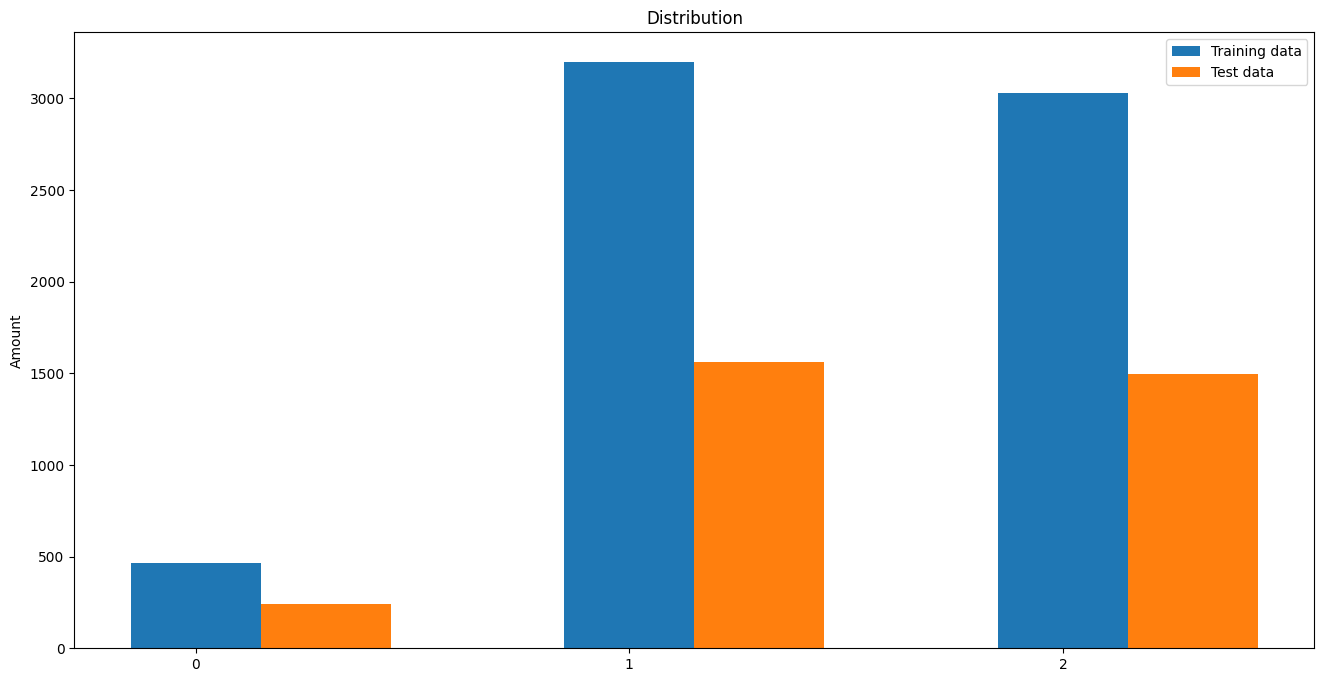

In [305]:
plt.figure(figsize=(16,8))
train_labels_data = y_train_distinct_labels_counts
test_labels_data = y_test_distinct_labels_counts
width = 0.3
y_pos = np.arange(len(distinct_labels))
plt.xticks(y_pos, distinct_labels)
plt.ylabel('Amount')
plt.title('Distribution')
plt.bar(np.arange(len(train_labels_data)), train_labels_data, width=width, label="Training data")
plt.bar(np.arange(len(test_labels_data))+ width, test_labels_data, width=width, label="Test data")
plt.legend()
plt.show()

In [306]:
X_train

array([[1, 1, 2, 1, 2],
       [1, 2, 1, 1, 1],
       [2, 0, 1, 2, 2],
       ...,
       [1, 2, 1, 1, 2],
       [2, 0, 2, 2, 2],
       [1, 1, 2, 2, 1]])

In [307]:
y_train

array([2, 1, 2, ..., 1, 2, 1])

In [407]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(DATA_CHUNK_SIZE, 1)),
    tf.keras.layers.Conv1D(32, kernel_size=3, activation='relu'),
    tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax'),
    tf.keras.layers.Dense(3)
])

optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [410]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(DATA_CHUNK_SIZE,)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax'),
    tf.keras.layers.Dense(3)
])

optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [411]:
epochs=50
def model_fit(model, X_train, y_train, X_test, y_test, epochs):
    with tf.device('/device:GPU:0'):
        history = model.fit(X_train,y_train, epochs=epochs, validation_data=(X_test, y_test), callbacks=[tensorboard_callback])
        return history

def display_accurracy_and_loss_graphs(history):
    plt.figure(figsize=(14,7))
    plt.plot(history.history['accuracy'], label= 'train')
    plt.plot(history.history['val_accuracy'], label= 'test')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.yticks(np.arange(0, 1.1, step=0.1))
    plt.legend()
    
    plt.figure(figsize=(14,7))
    plt.plot(history.history['loss'], label= 'train')
    plt.plot(history.history['val_loss'], label= 'test')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

Epoch 1/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.4726 - loss: 0.9734 - val_accuracy: 0.4801 - val_loss: 0.9004
Epoch 2/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4600 - loss: 0.9060 - val_accuracy: 0.4801 - val_loss: 0.8958
Epoch 3/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4836 - loss: 0.8917 - val_accuracy: 0.4801 - val_loss: 0.8946
Epoch 4/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4845 - loss: 0.8985 - val_accuracy: 0.4801 - val_loss: 0.8943
Epoch 5/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4828 - loss: 0.9064 - val_accuracy: 0.4801 - val_loss: 0.8944
Epoch 6/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4753 - loss: 0.9070 - val_accuracy: 0.4801 - val_loss: 0.8940
Epoch 7/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4737 - loss: 0.9112 - val_accuracy: 0.4801 - val_loss: 0.8940
Epoch 8/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4848 - loss: 0.8930 - val_accuracy: 0.

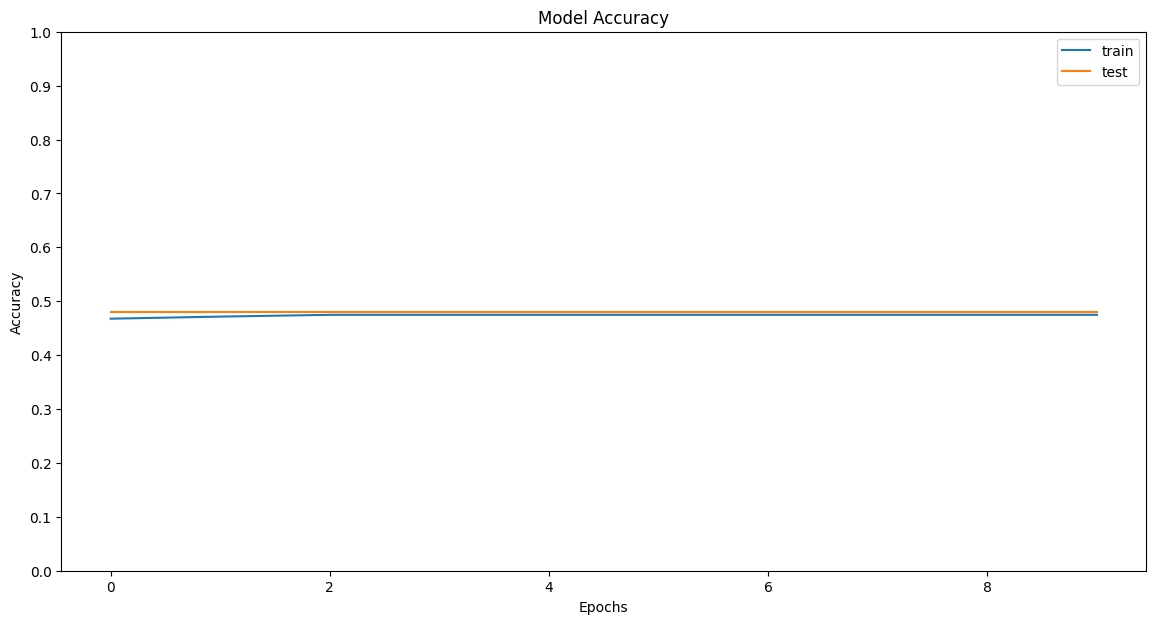

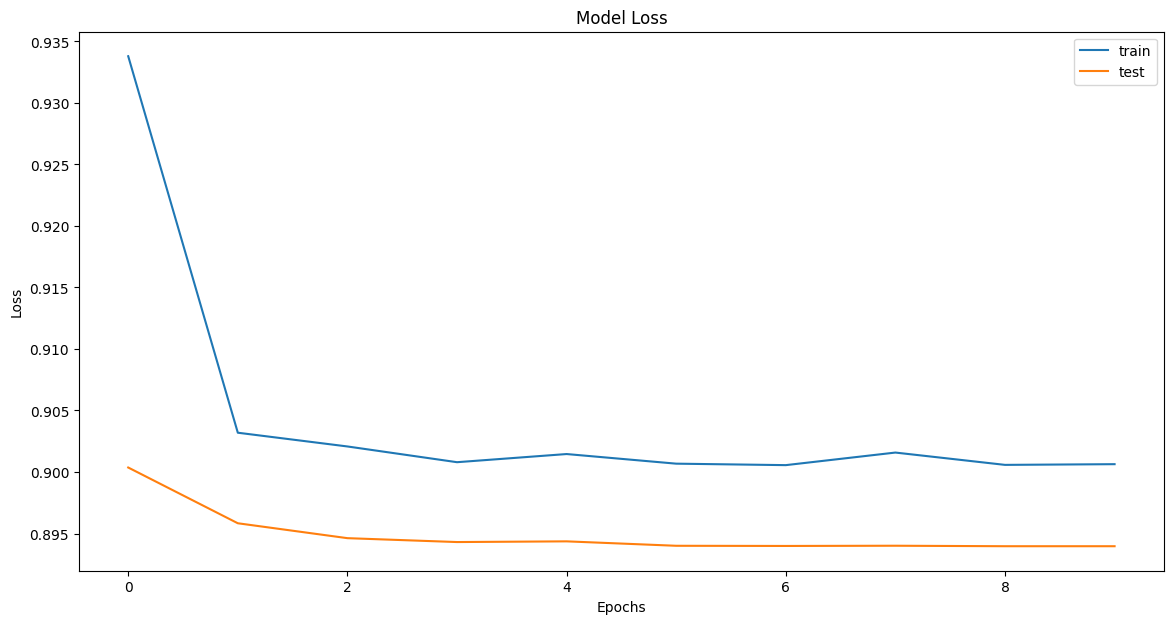

In [412]:
history = model_fit(model, X_train, y_train, X_test, y_test, 10)
display_accurracy_and_loss_graphs(history)

In [452]:
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
predictions = probability_model.predict(X_test)
predictions

104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


array([[0.07135937, 0.47526684, 0.4533738 ],
       [0.07135998, 0.47526807, 0.45337188],
       [0.07136337, 0.4752742 , 0.4533624 ],
       ...,
       [0.07146977, 0.47533098, 0.45319918],
       [0.0715098 , 0.4753794 , 0.45311084],
       [0.07143743, 0.47522235, 0.45334023]], dtype=float32)

In [453]:
def test_threshold(threshold, predictions, real_labels):
    correct = 0
    wrong = 0
    
    for probability_arr, label in zip(predictions,real_labels):
        max_probability = max(probability_arr)
        if max_probability < threshold:
            continue
        predicted_label = list(probability_arr).index(max_probability)
        if predicted_label == label:
            correct += 1
        else:
            wrong += 1
    if correct == 0 and wrong == 0:
        print(f"No data reaching {threshold} threshold")
        return 
    print(f"For threshold set to {threshold}, correctness is: {correct*100/max(1, correct+wrong)}%")

In [454]:
test_threshold(0.50, predictions, y_test)

No data reaching 0.5 threshold
